In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)
tf.random.set_seed(11)
from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df1 = pd.read_csv('/content/drive/My Drive/N.csv')
df1.head()
df2 = pd.read_csv('/content/drive/My Drive/F.csv')
df2.head()

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,X1_OutputPower,Y1_ActualPosition,Y1_ActualVelocity,Y1_ActualAcceleration,Y1_CommandPosition,Y1_CommandVelocity,Y1_CommandAcceleration,Y1_CurrentFeedback,Y1_DCBusVoltage,Y1_OutputCurrent,Y1_OutputVoltage,Y1_OutputPower,Z1_ActualPosition,Z1_ActualVelocity,Z1_ActualAcceleration,Z1_CommandPosition,Z1_CommandVelocity,Z1_CommandAcceleration,Z1_CurrentFeedback,Z1_DCBusVoltage,Z1_OutputCurrent,Z1_OutputVoltage,S1_ActualPosition,S1_ActualVelocity,S1_ActualAcceleration,S1_CommandPosition,S1_CommandVelocity,S1_CommandAcceleration,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,class
0,198,0.000,6.25,198,0.0,0.0,-1.100,0.0191,328,1.670,0.0,158.0,-0.050,-31.3,158.0,0.0,0.0,-1.0500,0.0231,327,2.450,0.0,119.0,-0.025,-6.25,119.0,0.0,0.0,0,0,0,0,-978.0,0.00000,-0.50,-978.0,0.0,0,-0.415,0.0,328,0.0,-0.00001,12,1,2,50,1
1,198,0.025,18.80,198,0.0,0.0,0.499,0.0211,328,1.540,0.0,158.0,-0.025,-12.5,158.0,0.0,0.0,0.0623,0.0217,327,1.160,0.0,119.0,0.000,0.00,119.0,0.0,0.0,0,0,0,0,-978.0,-0.00100,-0.75,-978.0,0.0,0,0.883,0.0,328,0.0,0.00000,12,1,0,50,1
2,198,0.000,12.50,198,0.0,0.0,1.140,0.0170,328,2.320,0.0,158.0,-0.025,-18.8,158.0,0.0,0.0,0.3740,0.0180,327,0.764,0.0,119.0,0.000,0.00,119.0,0.0,0.0,0,0,0,0,-978.0,0.00325,1.31,-978.0,0.0,0,-0.415,0.0,328,0.0,0.00000,12,1,0,50,1
3,198,0.000,0.00,198,0.0,0.0,-0.300,0.0152,328,0.812,0.0,158.0,-0.050,-25.0,158.0,0.0,0.0,-0.4130,0.0232,327,2.620,0.0,119.0,-0.025,-6.25,119.0,0.0,0.0,0,0,0,0,-978.0,0.00000,-0.25,-978.0,0.0,0,-0.152,0.0,328,0.0,-0.00001,12,1,0,50,1
4,198,0.000,0.00,198,0.0,0.0,-0.459,0.0237,328,1.120,0.0,158.0,-0.050,-25.0,158.0,0.0,0.0,-0.5700,0.0179,326,2.330,0.0,119.0,0.000,0.00,119.0,0.0,0.0,0,0,0,0,-978.0,0.00000,-0.25,-978.0,0.0,0,-0.679,0.0,327,0.0,0.00000,12,1,0,50,1


In [ ]:
df2 = df2.sample(3327)
df = df1.append(df2,ignore_index= True)
df.shape

(15305, 48)

In [ ]:
input_X = df.loc[:, df.columns != 'class'].values  # converts the df to a numpy array

input_y = df['class'].values

n_features = input_X.shape[1]  # number of features

In [ ]:
print(n_features)

47


In [ ]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X) - lookback - 1):
        t = []
        for j in range(1, lookback + 1):
            # Gather the past records upto the lookback period
            t.append(X[[(i + j + 1)], :])
        output_X.append(t)
        output_y.append(y[i + lookback + 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

In [ ]:
lookback = 12
# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)
display(pd.DataFrame(np.concatenate(X[np.where(np.array(y) == 1)[0][0]], axis=0 )))
print(X)

,0
0,157.000
1,2.950
2,18.800
3,157.000
4,3.000
...,...
559,0.164
560,12.000
561,1.000
562,15.000


[[[ 1.96e+02 -1.78e+01 -6.25e+00 ...  1.00e+00  7.00e+00  5.00e+01]
  [ 1.94e+02 -1.80e+01  0.00e+00 ...  1.00e+00  7.00e+00  5.00e+01]
  [ 1.93e+02 -1.79e+01 -1.88e+01 ...  1.00e+00  7.00e+00  5.00e+01]
  ...
  [ 1.80e+02 -1.77e+01  6.25e+01 ...  1.00e+00  7.00e+00  5.00e+01]
  [ 1.78e+02 -1.79e+01 -3.75e+01 ...  1.00e+00  7.00e+00  5.00e+01]
  [ 1.76e+02 -1.78e+01  1.06e+02 ...  1.00e+00  7.00e+00  5.00e+01]]

 [[ 1.94e+02 -1.80e+01  0.00e+00 ...  1.00e+00  7.00e+00  5.00e+01]
  [ 1.93e+02 -1.79e+01 -1.88e+01 ...  1.00e+00  7.00e+00  5.00e+01]
  [ 1.91e+02 -1.76e+01  8.12e+01 ...  1.00e+00  7.00e+00  5.00e+01]
  ...
  [ 1.78e+02 -1.79e+01 -3.75e+01 ...  1.00e+00  7.00e+00  5.00e+01]
  [ 1.76e+02 -1.78e+01  1.06e+02 ...  1.00e+00  7.00e+00  5.00e+01]
  [ 1.75e+02 -1.78e+01  4.38e+01 ...  1.00e+00  7.00e+00  5.00e+01]]

 [[ 1.93e+02 -1.79e+01 -1.88e+01 ...  1.00e+00  7.00e+00  5.00e+01]
  [ 1.91e+02 -1.76e+01  8.12e+01 ...  1.00e+00  7.00e+00  5.00e+01]
  [ 1.89e+02 -1.79e+01 -6.25e+00

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [ ]:
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]
X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

In [ ]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)
X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

In [ ]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [ ]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))

In [ ]:
X_train_y0_scaled = scale(X_train_y0, scaler)

In [ ]:
a = flatten(X_train_y0_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [ 0.  0.  0.  0. -0. -0.  0. -0. -0.  0.  0. -0. -0. -0. -0.  0.  0. -0.
  0.  0.  0. -0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0. -0.  0.  0. -0.
  0. -0. -0. -0. -0.  0.  0.  0. -0. -0.  0.]
colwise variance [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]


In [ ]:
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)
X_test_scaled = scale(X_test, scaler)

In [ ]:
timesteps =  X_train_y0_scaled.shape[1] 
n_features =  X_train_y0_scaled.shape[2] 
print(timesteps, n_features)
epochs = 200
batch = 64
lr = 0.0001

12 47


In [ ]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(128, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(64, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(64, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(128, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 128)           90112     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 12, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 12, 64)            33024     
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 128)           98816     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 47)            6063      
Total params: 277,423
Trainable params: 277,423
Non-trainable params: 0
________________________________________________

In [ ]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=2).history

Train on 7662 samples, validate on 1908 samples
Epoch 1/200
 - 14s - loss: 0.8004 - val_loss: 0.6835
Epoch 2/200
 - 11s - loss: 0.6205 - val_loss: 0.5800
Epoch 3/200
 - 11s - loss: 0.5373 - val_loss: 0.5177
Epoch 4/200
 - 11s - loss: 0.4911 - val_loss: 0.4843
Epoch 5/200
 - 11s - loss: 0.4616 - val_loss: 0.4563
Epoch 6/200
 - 11s - loss: 0.4447 - val_loss: 0.4529
Epoch 7/200
 - 11s - loss: 0.4279 - val_loss: 0.4274
Epoch 8/200
 - 11s - loss: 0.4117 - val_loss: 0.4138
Epoch 9/200
 - 11s - loss: 0.3982 - val_loss: 0.4028
Epoch 10/200
 - 11s - loss: 0.3866 - val_loss: 0.3909
Epoch 11/200
 - 11s - loss: 0.3783 - val_loss: 0.3829
Epoch 12/200
 - 11s - loss: 0.3684 - val_loss: 0.3748
Epoch 13/200
 - 11s - loss: 0.3599 - val_loss: 0.3694
Epoch 14/200
 - 11s - loss: 0.3535 - val_loss: 0.3619
Epoch 15/200
 - 11s - loss: 0.3469 - val_loss: 0.3558
Epoch 16/200
 - 11s - loss: 0.3417 - val_loss: 0.3556
Epoch 17/200
 - 11s - loss: 0.3385 - val_loss: 0.3468
Epoch 18/200
 - 11s - loss: 0.3306 - val_lo

In [ ]:
lstm_autoencoder.save('/content/drive/My Drive/paper_milling_lstm_AE')
lstm_autoencoder.save('/content/drive/My Drive/paper_milling_lstm_AE.h5')
# hist = pd.DataFrame(lstm_autoencoder_history.history)
# hist.to_csv('/content/drive/My Drive/milling_lstm_AE.csv', header=False, index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

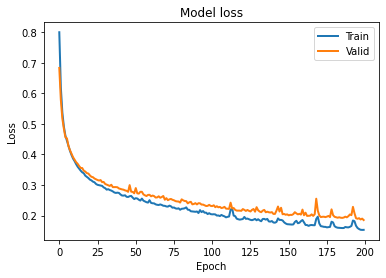

In [ ]:
from google.colab import files
train = plt.figure()
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
train.show()
train.savefig('train.png')
files.download('train.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reconstruction error threshold:  15.728347049463126


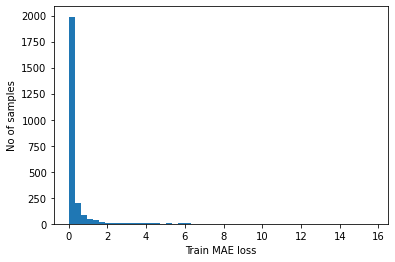

In [ ]:
valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)
hist = plt.figure()
plt.hist(mse, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
hist.show()
hist.savefig('hist.png')
files.download('hist.png')
# Get reconstruction loss threshold.
threshold = np.max(mse)
print("Reconstruction error threshold: ", threshold)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

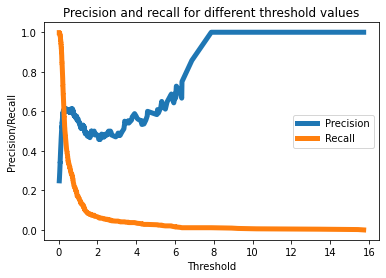

In [ ]:
# valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)
# mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
p = plt.figure()
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
p.show()
p.savefig('P&T.png')
files.download('P&T.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

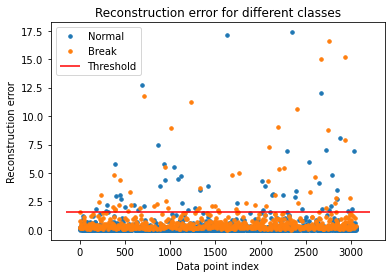

In [ ]:
test_x_predictions = lstm_autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 1.6
groups = error_df.groupby('True_class')
pp = plt.figure()
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
pp.savefig('plot.png')
pp.show()
files.download('plot.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

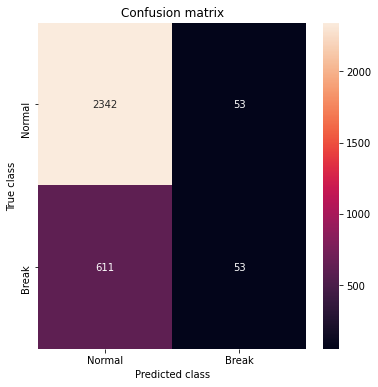

In [ ]:
from google.colab import files
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

cm = plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");

plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
cm.show()
cm.savefig('matrix.png')
files.download('matrix.png')

In [ ]:
cm.savefig('confusion_matrix.png')
files.download('confusion_matrix.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

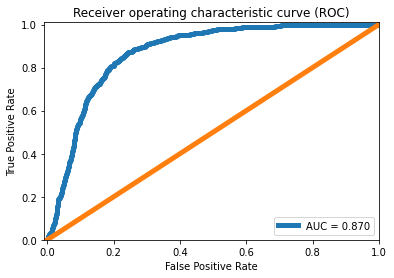

In [ ]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
roc = plt.figure()
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
roc.show()
roc.savefig('ROC.png')
files.download('ROC.png')